In [ ]:



import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'crop-pest-and-disease-detection:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4280832%2F7368427%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240210%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240210T090759Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2fd709f1ae581f83066e5de8ea6969a4a9b897e1800231a3fa5af652276d1b55f831202374fb1cc851920d99f8689c5d3651824e1925ef6cf644fb4434bfbfab38b3be45190d088949e8452dfbe14cb5a1a55b4edac070fce33176a61dac5b694d17e8148cb0598d1661a83ff714695e078b0c9b6e7356db0c8340363ab1ae4628fd192dcb8b25f1082de8a0334eeb94d8ae95499b6b45f88fabd0e0b76deaf95f175453866db43b9e24533cced470b598d8482b5dfc5c596be04a30a48e3f690ca3c33aa20e4738dd867bbf2d1c039b0751d20062b0f0ba2c9b21c64f3d60feeff3decf7fc7dd28fc39c0f3064bbc5bb96cf1320cf56ed9384d5b0a9a7fcf8d'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1337579661 bytes downloaded
Downloaded and uncompressed: crop-pest-and-disease-detection
Data source import complete.


In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
EPOCHS = 10
IMAGE_SIZE = (128, 128)
INPUT_SHAPE = (128, 128, 3)
DATASET_DIR = "/kaggle/input/crop-pest-and-disease-detection"
BATCH_SIZE = 64
LEARNING_RATE = 0.001
MAX_IMAGES_PER_CATEGORY = 5000
CLASS_NAMES = ['Cashew', 'Cassava', 'Maize', 'Tomato']

### Helper Functions for Processing Data

In [ ]:
"""
    Get the disease category from the file path

    @param file_path - the path to the image file
    @returns the category of the disease
"""
def get_disease_category_by_path(file_path):
    return file_path.split("/")[4]

"""
    Get the plant category from the file path

    @param file_path - the path to the image file
    @returns the category of the plant
"""
def get_plant_category_by_path(file_path):
  disease_category = get_disease_category_by_path(file_path)
  return disease_category.split(" ")[0]

In [ ]:
"""
    Convert a dataset of images to tensors

    @param images - the list of images to convert
    @returns a list of images as tensors
"""
def process_images(images):
  image_list = []

  for filename in images:
    img = tf.io.read_file(filename)
    img = tf.io.decode_jpeg(img)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)

    image_list.append(img)

  return image_list

In [ ]:
"""
    Remove invalid images from dataframe

    @param df - dataframe containing image filenames
    @returns a dataframe with only valid images in the filename col
"""
def clean_image_dataframe(df):
  for image in df['filename']:
    try:
      img = tf.io.read_file(image)
      img = tf.io.decode_jpeg(img)
    except:
      index = df[(df.filename == image)].index
      df = df.drop(index)
  return df

In [ ]:
"""
    Encode the target label

    @param label - the target label to be encoded
    @return a encoded label
"""
def encode_label(label):
  if label == 'Cashew':
    return 0
  elif label == 'Cassava':
    return 1
  elif label == 'Maize':
    return 2
  elif label == 'Tomato':
    return 3
  else:
    return -1

### Perform EDA (Exploratory Data Analysis)

In [ ]:
filenames = []
plant_category = []
disease_category = []

# sort the categories and filenames into lists
for (root, dirs, files) in os.walk(DATASET_DIR):
  for filename in files:
    fn = str(root + "/" + filename)
    filenames.append(fn)

    pc = get_plant_category_by_path(fn)
    plant_category.append(pc)

    dc = get_disease_category_by_path(fn)
    disease_category.append(dc)

In [ ]:
# create a Pandas dataframe using the lists
data = { "filename": filenames, "plant category": plant_category, "disease category": disease_category }
df = pd.DataFrame(data)
df = df.sample(frac=1)  # shuffle the dataframe

print(df.head(10))

                                                filename plant category  \
2515   /kaggle/input/crop-pest-and-disease-detection/...         Tomato   
3390   /kaggle/input/crop-pest-and-disease-detection/...        Cassava   
18514  /kaggle/input/crop-pest-and-disease-detection/...          Maize   
17669  /kaggle/input/crop-pest-and-disease-detection/...          Maize   
12117  /kaggle/input/crop-pest-and-disease-detection/...         Cashew   
11720  /kaggle/input/crop-pest-and-disease-detection/...         Cashew   
14699  /kaggle/input/crop-pest-and-disease-detection/...        Cassava   
18504  /kaggle/input/crop-pest-and-disease-detection/...          Maize   
17557  /kaggle/input/crop-pest-and-disease-detection/...          Maize   
11193  /kaggle/input/crop-pest-and-disease-detection/...         Cashew   

                disease category  
2515   Tomato septoria leaf spot  
3390          Cassava brown spot  
18514        Maize fall armyworm  
17669          Maize leaf beetle  

In [ ]:
# remove invalid images from the dataframe
df = clean_image_dataframe(df)
print(f"Length of DF: {len(df['filename'])}")

Length of DF: 25124


In [ ]:
category_sizes = df.groupby("plant category").size()
print(category_sizes)

plant category
Cashew     6549
Cassava    7508
Maize      5288
Tomato     5779
dtype: int64


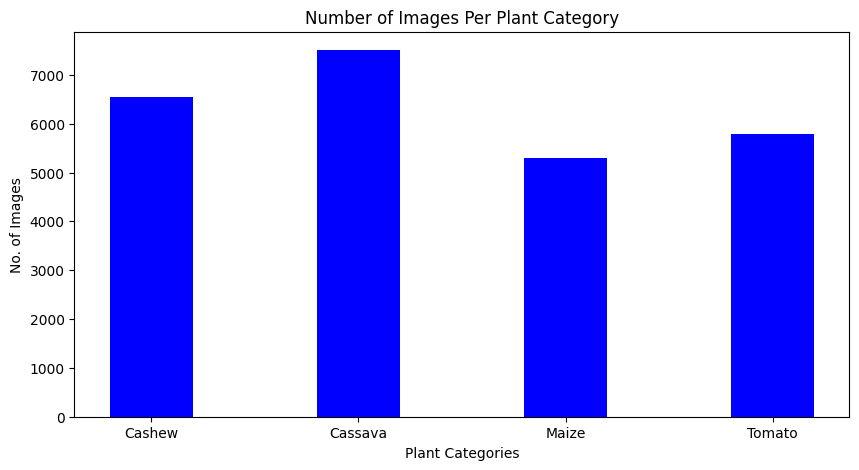

In [ ]:
categories = df['plant category'].sort_values().unique()

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(categories, category_sizes, color ='blue',
        width = 0.4)

plt.xlabel("Plant Categories")
plt.ylabel("No. of Images")
plt.title("Number of Images Per Plant Category")
plt.show()

### Create a Balanced Training Dataset and Validation Dataset

We have an unbalanced set of images. There are nearly 20% more Cassava images than Maize images. Let's use only 5000 images from each category to create the training and validation datasets.
We can use the remaining images to create a test dataset for evaluating the model after training.

In [ ]:
# truncate the number of images in each category so each have an equal amount
cashew_files = [df['filename'].values[index] for index, x in enumerate(df['plant category'].values) if 'Cashew' == x][0:MAX_IMAGES_PER_CATEGORY]
cassava_files = [df['filename'].values[index] for index, x in enumerate(df['plant category'].values) if 'Cassava' == x][0:MAX_IMAGES_PER_CATEGORY]
maize_files = [df['filename'].values[index] for index, x in enumerate(df['plant category'].values) if 'Maize' == x][0:MAX_IMAGES_PER_CATEGORY]
tomato_files = [df['filename'].values[index] for index, x in enumerate(df['plant category'].values) if 'Tomato' == x][0:MAX_IMAGES_PER_CATEGORY]

dataset = []

def create_dataset(filenames, label):
  for filename in filenames:
    data_subset = []
    data_subset.append(filename)
    data_subset.append(encode_label(label))

    dataset.append(data_subset)

create_dataset(cashew_files, 'Cashew')
create_dataset(cassava_files, 'Cassava')
create_dataset(maize_files, 'Maize')
create_dataset(tomato_files, 'Tomato')

unbalanced_dataset_size = len(df['filename'].unique())
balanced_dataset_size = len(dataset)
loss = round((1 - (balanced_dataset_size / unbalanced_dataset_size)) * 100, 2)

print(f"Size of Unbalanced Dataset: {unbalanced_dataset_size}")
print(f"Size of Balanced Dataset: {balanced_dataset_size}")

Size of Unbalanced Dataset: 25124
Size of Balanced Dataset: 20000


In [ ]:
dataset_df = pd.DataFrame(dataset, columns=['filename', 'label'])
print(dataset_df.head())

                                            filename  label
0  /kaggle/input/crop-pest-and-disease-detection/...      0
1  /kaggle/input/crop-pest-and-disease-detection/...      0
2  /kaggle/input/crop-pest-and-disease-detection/...      0
3  /kaggle/input/crop-pest-and-disease-detection/...      0
4  /kaggle/input/crop-pest-and-disease-detection/...      0


In [ ]:
X = dataset_df['filename']
y = dataset_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [ ]:
X_train = process_images(X_train)
X_test = process_images(X_test)

In [ ]:
X_train = tf.data.Dataset.from_tensor_slices(X_train)
y_train = tf.data.Dataset.from_tensor_slices(y_train)

X_test = tf.data.Dataset.from_tensor_slices(X_test)
y_test = tf.data.Dataset.from_tensor_slices(y_test)

train_ds = tf.data.Dataset.zip((X_train, y_train))
validation_ds = tf.data.Dataset.zip((X_test, y_test))

In [ ]:
train_ds = train_ds.cache().shuffle(buffer_size=1024).prefetch(buffer_size=tf.data.AUTOTUNE).batch(BATCH_SIZE)
validation_ds = validation_ds.batch(BATCH_SIZE)

### Visualize a Subset of the Training Dataset

In [ ]:
plt.figure(figsize=(12,9))
for image, label in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[i].numpy().astype("uint8"))
    plt.title(CLASS_NAMES[label[i]])
    plt.axis("off")

#### Generate a Test Dataset from Remaining Images After Truncation

In [ ]:
# Take the remaining images and create a test set that won't be seen during training
STARTING_POINT = MAX_IMAGES_PER_CATEGORY + 1
cashew_files = [df['filename'].values[index] for index, x in enumerate(df['plant category'].values) if 'Cashew' == x][STARTING_POINT:]
cassava_files = [df['filename'].values[index] for index, x in enumerate(df['plant category'].values) if 'Cassava' == x][STARTING_POINT:]
maize_files = [df['filename'].values[index] for index, x in enumerate(df['plant category'].values) if 'Maize' == x][STARTING_POINT:]
tomato_files = [df['filename'].values[index] for index, x in enumerate(df['plant category'].values) if 'Tomato' == x][STARTING_POINT:]

test_dataset = []

def create_test_dataset(filenames, label):
  for filename in filenames:
    data_subset = []
    data_subset.append(filename)
    data_subset.append(encode_label(label))

    test_dataset.append(data_subset)

create_test_dataset(cashew_files, 'Cashew')
create_test_dataset(cassava_files, 'Cassava')
create_test_dataset(maize_files, 'Maize')
create_test_dataset(tomato_files, 'Tomato')

test_dataset_size = len(test_dataset)
print(f"Size of Test Dataset: {test_dataset_size}")

test_dataset_df = pd.DataFrame(test_dataset, columns=['filename', 'label'])
print(test_dataset_df.head())

test_images = process_images(test_dataset_df['filename'])
test_labels = test_dataset_df['label']

test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_ds = test_ds.batch(BATCH_SIZE)

In [ ]:
base_model = tf.keras.applications.VGG16(
    include_top = False,
    input_shape=INPUT_SHAPE,
    weights="imagenet"
)
base_model.trainable = False

base_model.summary()

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4)
])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])

In [ ]:
history = model.fit(train_ds, epochs=EPOCHS, validation_data=validation_ds)

### **Classification Report**

In [ ]:
print(model.evaluate(test_ds, return_dict=True))

In [ ]:
metrics = history.history
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['training', 'validation'])
plt.ylim([0, max(plt.ylim())])
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(1, 2, 2)
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['training', 'validation'])
plt.ylim([0, 1])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

In [ ]:
y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=CLASS_NAMES,
            yticklabels=CLASS_NAMES,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
print(y_pred)

In [ ]:
plt.figure(figsize=(12,9))
for image, label in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[i].numpy().astype("uint8"))
    plt.title(f"Predicted: {CLASS_NAMES[y_pred[i]]} - True: {CLASS_NAMES[y_true[i]]}")
    plt.axis("off")